# Graph Attention Networks

Graph Attention Networks, Petar Veličković, Guillem Cucurull, Arantxa Casanova, Adriana Romero, Pietro Liò, Yoshua Bengio. https://arxiv.org/abs/1710.10903

- Node degrees are not equivalent, which have been taken into account with the normalization coefficients in GCN model.

> $h_A = \sum\limits_{i\in N_A}x_iW^T = \sum\limits_{i\in N_A} Wx_i$

- Node features are also not equivalent. This chapter will include the node feature unequivalence by inserting weight factors or self attention scores $\alpha_{Ai}$.

> $h_A = \sum\limits_{i\in N_A} \alpha_{Ai} Wx_i$

- Attention score is contributed from both target and neighbor nodes. Therefore, it is formulated by concatenating hidden vectors $Wx_A$ and $Wx_i$:

> $\alpha_{Ai} = W^T_{att} [Wx_A || Wx_i]$


In [1]:
# import dataset
try:
    from torch_geometric.datasets import Planetoid
except:
    !pip install -q torch-geometric
    from torch_geometric.datasets import Planetoid

# download cora dataset
cora_dataset = Planetoid(root=".", name="Cora")
cora_data = cora_dataset[0]

Processing...
Done!


In [2]:
import torch
from torch.nn import functional
from torch_geometric.nn import GATv2Conv

class GAT(torch.nn.Module):
    def __init__(self, dim_in:int, dim_h:int, dim_out:int, heads:int=8):
        super().__init__()
        self.gat1 = GATv2Conv(in_channels=dim_in, out_channels=dim_h, heads=heads)
        self.gat2 = GATv2Conv(in_channels=dim_h*heads, out_channels=dim_out, heads=1)
    def forward(self, x, edge_index):
        x = functional.dropout(x, p=0.6, training=self.training)
        x = self.gat1(x, edge_index)
        x = functional.elu(x)
        x = functional.dropout(x, p=0.6, training=self.training)
        x = self.gat2(x, edge_index)
        return functional.log_softmax(x, dim=1)

In [3]:
# gat instance for cora dataset
cora_model = GAT(
    dim_in=cora_dataset.num_features,
    dim_h=32,
    dim_out=cora_dataset.num_classes
)
cora_model

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)

In [4]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cora_model.parameters(), lr=1e-2, weight_decay=1e-2)

In [5]:
from sources.revisited_engine import train, test

cora_results = train(
    model=cora_model,
    data=cora_data,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=101
)

  0%|          | 0/101 [00:00<?, ?it/s]

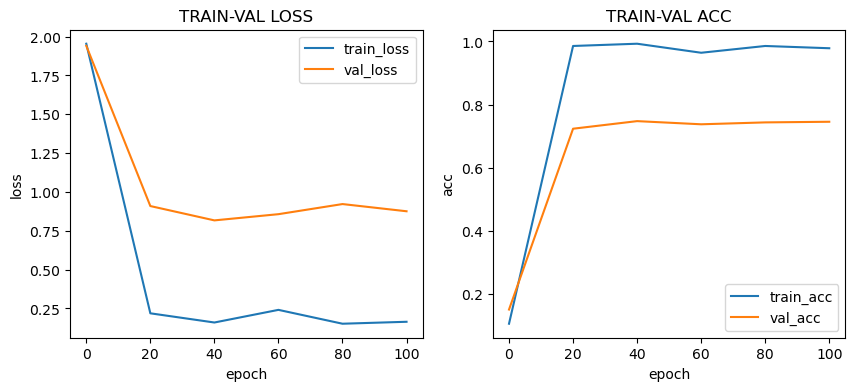

In [6]:
# visualize training results for cora dataset
from sources.revisited_utils import visualize_results

visualize_results(results=cora_results)

In [7]:
# test accuracy for cora dataset training
test_acc = test(
    model=cora_model,
    data=cora_data)
print(f"Test accuracy: {test_acc*100:.1f}(%)")

Test accuracy: 83.4(%)


# Applying GAT for CiteSeer dataset

In [8]:
# Download CiteSeer dataset
cite_seer_dataset = Planetoid(root='.', name='CiteSeer')
cite_seer_data = cite_seer_dataset[0]
cite_seer_data

Processing...
Done!


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

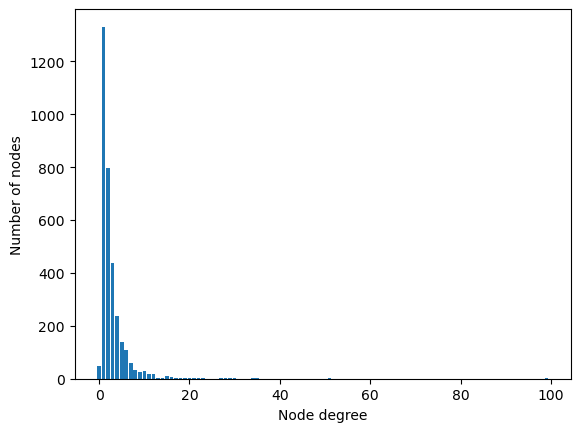

In [9]:
# visualize node degree of CiteSeer dataset
from sources.revisited_utils import visualize_node_degree

visualize_node_degree(data=cite_seer_data)

In [10]:
# create a GAT instance for CiteSeer
cite_seer_model = GAT(
    dim_in=cite_seer_dataset.num_features,
    dim_h=16,
    dim_out=cite_seer_dataset.num_classes
)
cite_seer_model

GAT(
  (gat1): GATv2Conv(3703, 16, heads=8)
  (gat2): GATv2Conv(128, 6, heads=1)
)

In [11]:
# loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cite_seer_model.parameters(), lr=1e-2, weight_decay=1e-2)

In [12]:
# train GAT for CiteSeer dataset
cite_seer_results = train(
    model=cite_seer_model,
    data=cite_seer_data,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=101
)

  0%|          | 0/101 [00:00<?, ?it/s]

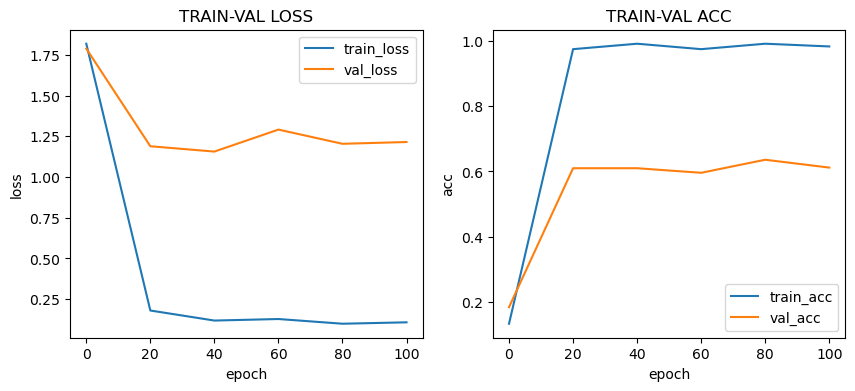

In [13]:
# visualize results
visualize_results(results=cite_seer_results)

In [14]:
# check test accuracy
test_acc = test(
    model=cite_seer_model,
    data=cite_seer_data
)
print(f"Test accuracy: {test_acc*100:.1f}(%)")

Test accuracy: 66.0(%)
